In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

print(torch.cuda.is_available())
print(torch.cuda.device_count)

2.5.1+cu124
0.20.1+cu124
False
<function device_count at 0x7833e814dd00>


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 31.19 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
# Get Data

import os
import zipfile

from pathlib import Path

import requests

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
      request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
      print("Downloading pizza, steak, sushi data...")
      f.write(request.content)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)
    os.remove(data_path / "pizza_steak_sushi.zip")


Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
# Create Datasets and DataLoaders

from torchvision import transforms
from going_modular.going_modular import data_setup

In [7]:
# Manual Transform

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_tranforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [8]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_tranforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7832f7ad2b50>,
 ['pizza', 'steak', 'sushi'])

In [9]:
# Automatic Transform

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoaders using Automatic Transformers
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7832f7ae5bd0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
# Pre-trained Models Loading

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 102MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [14]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [15]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [19]:
# Freezing the Base model and changing the output layer to suit our needs

for param in model.features.parameters():
  #print(param)
  param.requires_grad = False

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [20]:
len(class_names)

3

In [21]:
torch.manual_seed(42)

from torch import nn
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names),
              bias=True)).to(device)
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [22]:
# Train the Model

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
from going_modular.going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

results= engine.train(model=model,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      loss_fn=loss_fn,
                      optimizer=optimizer,
                      epochs=5,
                      device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9192 | train_acc: 0.6523 | test_loss: 0.7914 | test_acc: 0.8258
Epoch: 3 | train_loss: 0.7542 | train_acc: 0.8711 | test_loss: 0.6483 | test_acc: 0.9167
Epoch: 4 | train_loss: 0.7378 | train_acc: 0.7109 | test_loss: 0.5965 | test_acc: 0.8958
Epoch: 5 | train_loss: 0.6268 | train_acc: 0.7617 | test_loss: 0.6127 | test_acc: 0.8968
[INFO] Total training time: 163.875 seconds


In [26]:
results

{'train_loss': [1.096598893404007,
  0.9192043915390968,
  0.7541997358202934,
  0.7377770766615868,
  0.6267921589314938],
 'train_acc': [0.38671875, 0.65234375, 0.87109375, 0.7109375, 0.76171875],
 'test_loss': [0.8842612504959106,
  0.7913958231608073,
  0.6483494242032369,
  0.5965305964152018,
  0.6126677592595419],
 'test_acc': [0.6827651515151515,
  0.8257575757575758,
  0.9166666666666666,
  0.8958333333333334,
  0.8967803030303031]}

Couldn't import plot_loss_curves. Downloading
Downloaded helper_functions.py
Downloaded helper_functions.py


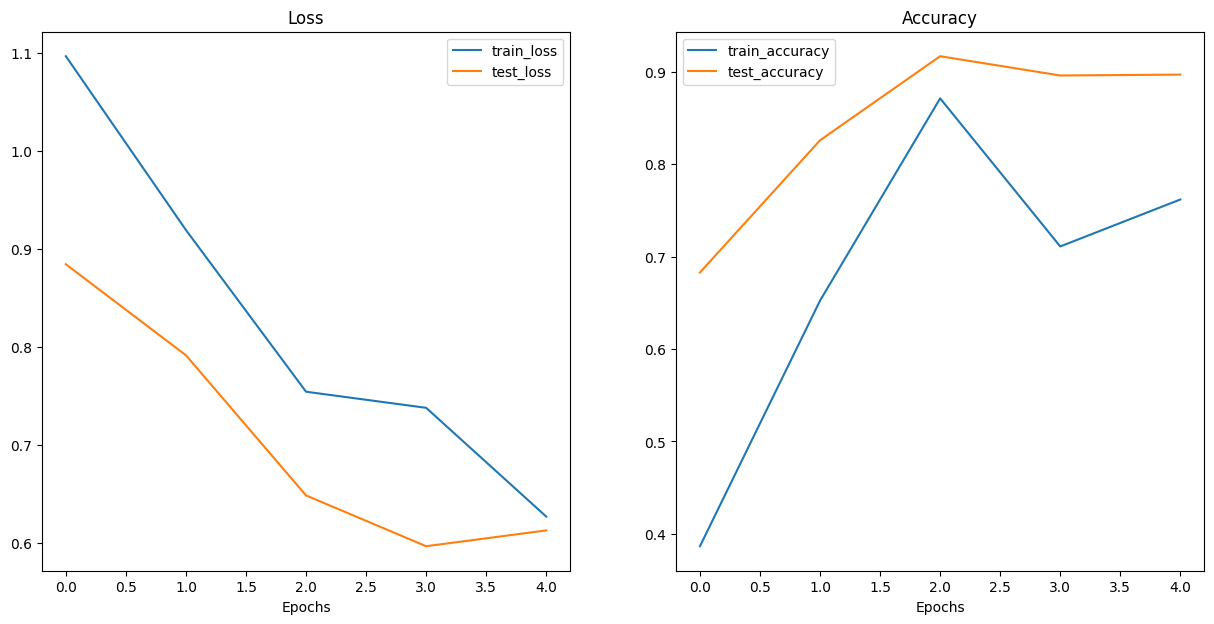

In [27]:
# Model the Plot Loss Curves

try:
  from helper_functions import plot_loss_curves
  print("Failed")
except:
  print(f"Couldn't import plot_loss_curves. Downloading")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    print("Downloaded helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves
  print("Downloaded helper_functions.py")

plot_loss_curves(results)


In [28]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False)



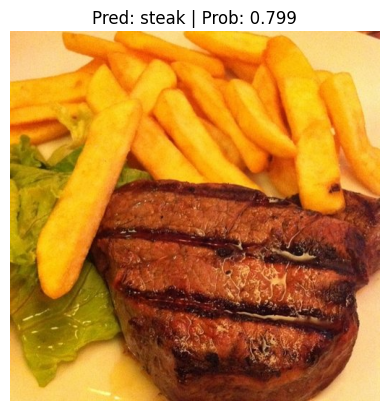

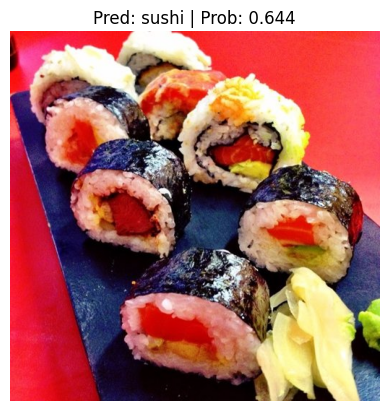

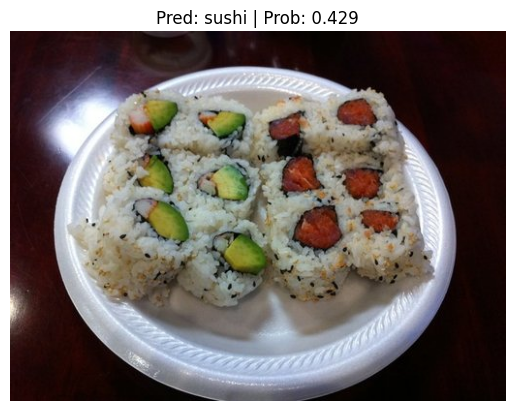

In [36]:
# Get a random list

import random
num_images_to_plot =3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

In [37]:
# Lets make prediction on custom Image

import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  print(f"{custom_image_path} not found, downloading...")
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_dad.jpeg")
    print("Downloaded custom image")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")


data/04-pizza-dad.jpeg not found, downloading...
Downloaded custom image
